## Week 4: Afternoon session - Clustering and regression with correlated high dimension data

This noteook has two main exercises:

* Apply k-means to find clusters in the synthetic drilling data and the Octane dataset.  If you wish to you can try doing this in the original high dimension dataset, but this will fail.  Instead try use the first few principal components that you've found in the example datasets.

* Train a linear regression model (least squares or robust, and using either Seaborn or scikit-learn - try them all if you'd like to!) on the drilling or Octane datasets.  You cannot use the datasets at their full dimension because there are less observations than there are features!  But you'll likely find that you train a model based on the PC-transformed features.  Use the code from the last session to do this.  You can start simple - Try to predict quartz based on the first PC.  Then build on this as you become more confident and ambitious! 

Also, see if you can find out how to use scikit-learn pipelines to implement this as a pipeline with a transform, followed by least-squares linear regression

This afternoon session also has one worked examples:it also has one worked example:

* Apply training, test and validation to our old friend the metal recovery model.

### K-means clustering in scikit-learn

The k-means algorithm searches for clusters in an unlabelled multidimensional (the of low dimension) dataset.  If you're dataset is high dimension that you'll need to reduce the dimension, using, for example, principal components.

It does this through a simple, but sometimes effective, formulation of what good clustering is.  It believes that the centre of a cluster should be the mean average of all of the points belonging to the cluster, and it believes that each point should be closer to its own cluster's centre than to any other.  This has many of the characteristics (and flaws) of the linear models we've been looking at over the last couple of weeks.  That said, it's often worth trying before more sophisticated approaches.

You can also easily find information on how to use k-means in scikit-learn through internet searches, but lets use a textbook example, then try applying this to another dataset.



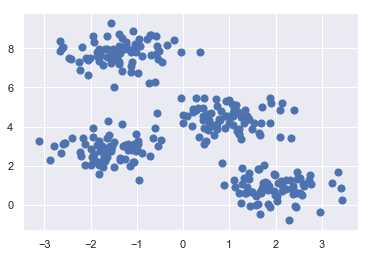

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                      cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50);

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

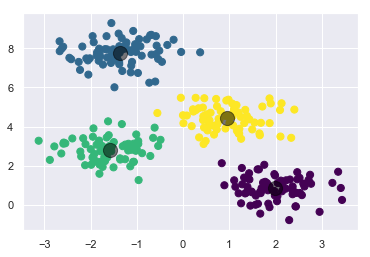

In [10]:
plt.scatter(X[:, 0], X[:,1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Now try this with some of the clusters that we observed this morning.

### Principal Components Regression:

This is something you can fully implement with what you already know.  First find the principal components and create a linear regression model between a component and a training set.  Make predictions on observations not in the training set.

### Model validation revisited

Let's use cross validation to fit a polynomial model to the metal recovery dataset.  This is analogous to hyperparameter selection that will be used for other scikit-learn models, and is the process that is used by scikit-learn's PLS modelling to create a good model.

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [22]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1)**2
    y = 10 - 1.0 / (X.ravel()+0.1)
    if err > 0:
        y+= err * rng.randn(N)
    return X, y

X, y = make_data(50)

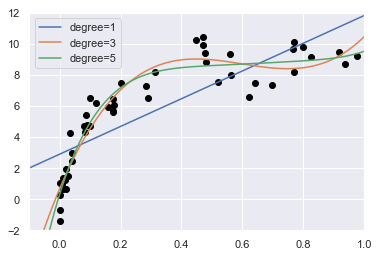

In [23]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color = 'black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

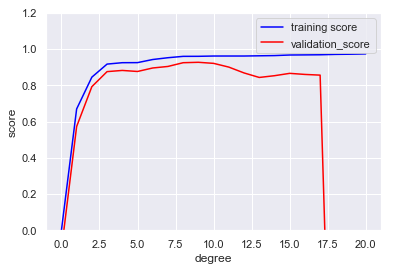

In [26]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y, 
                                         'polynomialfeatures__degree',
                                         degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation_score')
plt.legend(loc='best')
plt.ylim(0, 1.2)
plt.xlabel('degree')
plt.ylabel('score');

### Learning Curves

The optimal model will usually depend on how much training data you have.  Learning curves are a tool to identify when a model will be improved by more data, or whether it's already about as good as it will get (though a different kind of model may still work better).

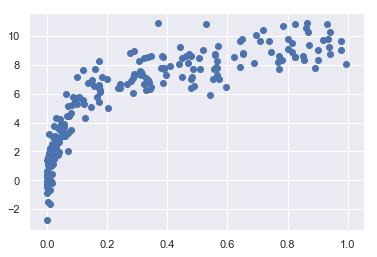

In [27]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

(0, 1)

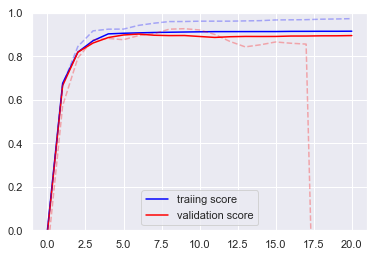

In [29]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree',
                                            degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue',
        label='traiing score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3,
         linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3,
        linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)

Learning Curves behave like this:

* A model of a given complexity will overfit a small dataset: this means the training score will be relatively high, while the validation score will be relatively low.

* A model of a given complexity will underfit a large dataset: this means that the training score will decrease, but the validation score will increase.

* A model will never, except by chance or a mistake in your code, give a better score to the validation set then the training set: this means the curves should keep getting closer together, but never cross.

* This all implies that if a model is being overfitted, then the behaviour may improve if you increase the size of the training set.  This is a reason why neural network models, with their high complexity, require lots of training data to behave well.  Conversely, when the training and validation curves have converged then you don't need to spend time, energy or money collecting more data (unless you intend to bring in a higher complexity model in future).
